In [2]:
# The RMSE and cosine similarity plots in sample_size.py suggest that increasing sample size 
# does not necessarily improve model performance.
# Later, I observed that model performance is influenced by the variance of the gamma parameter across features.
# This script demonstrates that higher gamma variance leads to greater vertical deviation from the ground truth.
import os
import pandas as pd
import numpy as np
import pickle
import sys
sys.path.append("/Users/xiaoqixie/Desktop/Mcgill/winter_rotation/Code_final")
from helper import neuro_combat_train,d_combat_train
import json
import matplotlib.pyplot as plt

default_path="/Users/xiaoqixie/Desktop/Mcgill/Winter_Rotation/combat_sites"

################################################################################
def func(N,simulation_times):
    """
    Estimates the RMSE by concatenating all harmonized data across 100 simulations for a given sample size.

    Parameters:
    - N (int): Sample size
    - simulation_times (int): Number of simulations performed

    Returns:
    - float: RMSE between the concatenated ground truth and harmonized data
    """
    path = os.path.join(default_path, f"test1/N{N}")

    harmonized_data = []
    for i in range(100):
        sim_path = os.path.join(path, f"simulation_{i}", "output_n.pkl")
        with open(sim_path, "rb") as f:
            output = pickle.load(f)
            harmonized_data.append(output["combat_data"])

    harmonized_data = np.concatenate(harmonized_data, axis=1)

    # Load and concatenate corresponding ground truth data
    ground_truth_data = []
    feature_cols = [f"ground_truth {i}" for i in range(100)]
    dtypes = {col: 'float32' for col in feature_cols}

    for i in range(simulation_times):
        csv_path = os.path.join(path, f"simulation_{i}", "data.csv")
        df = pd.read_csv(csv_path, usecols=feature_cols, dtype=dtypes).T
        ground_truth_data.append(df)

    ground_truth_data = pd.concat(ground_truth_data, axis=1)

    # print(harmonized_data.shape == ground_truth_data.shape)

    # Compute RMSE
    rmse = np.sqrt(np.mean((ground_truth_data - harmonized_data) ** 2))
    return rmse

# ################################################################################
N=1010
print(f"RMSE of N {N}",func(N,100))
###################################################################################
#Let's further look at rmse for simulations
path1 = os.path.join(default_path, 'test1', 'N1010')
rmse = []

for i in range(100):  # 100 simulations
    path2 = os.path.join(path1, f'simulation_{i}')

    # Load harmonized data
    with open(os.path.join(path2, "output_n.pkl"), "rb") as f:
        output = pickle.load(f)
    combat_data = output['combat_data']

    # Load ground truth
    data = pd.read_csv(os.path.join(path2, "data.csv"))
    gt_cols = [col for col in data.columns if "ground_truth" in col]
    gt = data[gt_cols].T

    # Compute RMSE
    value = np.sqrt(np.mean((gt - combat_data) ** 2))
    rmse.append(value)

rmse = np.array(rmse)
#Among 100 simulations, which simulation returns the highest rmse.
print("Max RMSE at simulation index:", np.argmax(rmse))
print("Max RMSE value:", np.max(rmse))

#It shows that simulation 35 has the highest rmse

RMSE of N 1010 5.256168737790559
Max RMSE at simulation index: 35
Max RMSE value: 40.656371570602985


In [45]:
#It shows that the highest rmse is observed in simulation 35.
#Compute the variance of gamma for each feature
path=os.path.join(default_path,'test1',f"N{1010}",f"simulation_{35}")
data=pd.read_csv(os.path.join(path,"data.csv"))
gt_cols=[col for col in data.columns if "ground_truth" in col]
ground_truth=data[gt_cols].T


with open(os.path.join(path,'output_n.pkl'),'rb') as f:
    output=pickle.load(f)
combat_data=output['combat_data']

with open(os.path.join(path,"params.json"),"r") as f:
    params=json.load(f)

gamma_df = pd.DataFrame(
    data=params["gamma"]["data"],
    columns=params["gamma"]["columns"],
    index=params["gamma"]["index"]
)

# Compute quantiles of gamma variance across features
gamma_var = gamma_df.var(axis=0)
quantiles = np.quantile(gamma_var, [0, 0.25, 0.5, 0.75,1])
print("Variance quantiles (min, 25%, median, 75%):", quantiles)

# Identify features with high variance
threshold_high=30000
print("High variance:",gamma_var[gamma_var > threshold_high])
high_var_cols = gamma_var[gamma_var > threshold_high]
position1 = high_var_cols.index.tolist()
print(f"Number of features with variance > {threshold_high}:", len(high_var_cols))
print(f"Columns with variance > {threshold_high}:", high_var_cols.index.tolist())

# Identify features with low variance
threshold_low = 500
low_var_cols = gamma_var[gamma_var < threshold_low]
position2=low_var_cols.index.tolist()
print(f"Number of features with variance < {threshold_low}:", len(low_var_cols))
print(f"Columns with variance < {threshold_low}:", low_var_cols.index.tolist())


Variance quantiles (min, 25%, median, 75%): [  401.89495998  2369.48259851  5142.15390238 11271.0334508
 35373.08300951]
High variance: feature_2     35373.083010
feature_25    30370.565261
feature_64    32571.350212
dtype: float64
Number of features with variance > 30000: 3
Columns with variance > 30000: ['feature_2', 'feature_25', 'feature_64']
Number of features with variance < 500: 3
Columns with variance < 500: ['feature_43', 'feature_49', 'feature_59']


2


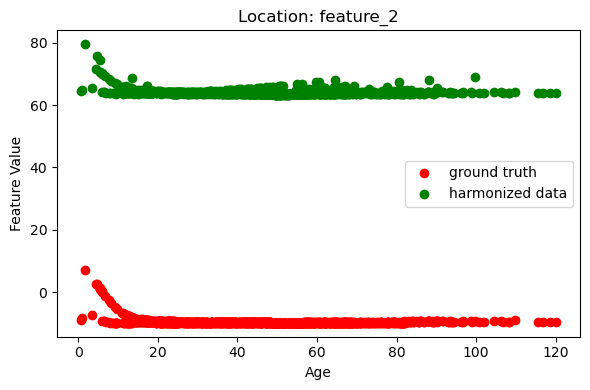

25


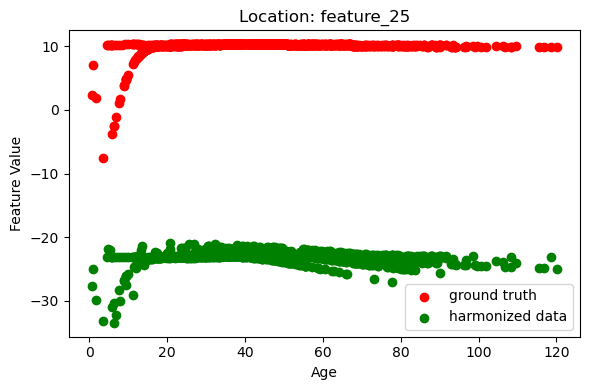

64


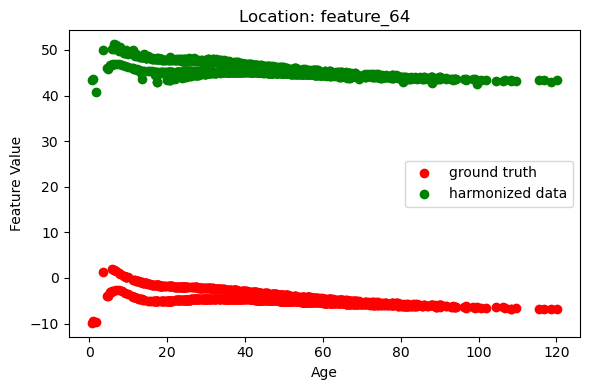

In [46]:
#plot for high variance
for i in position1:
    num = int(i.split('_')[1])
    # print(num)
    plt.figure(figsize=(6, 4))
    
    plt.scatter(data["age"], ground_truth.iloc[num, :], color="red",
                label="ground truth" )
    
    plt.scatter(data["age"], combat_data[num, :], color="green",
                label="harmonized data" )
    
    plt.xlabel("Age")
    plt.ylabel("Feature Value")
    plt.title(f"Location: {i}")
    plt.legend()
    plt.tight_layout()
    plt.show()

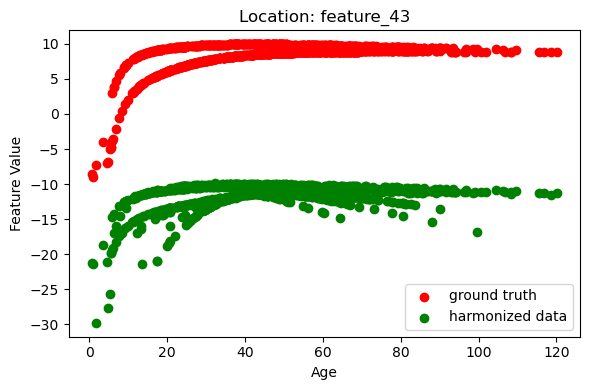

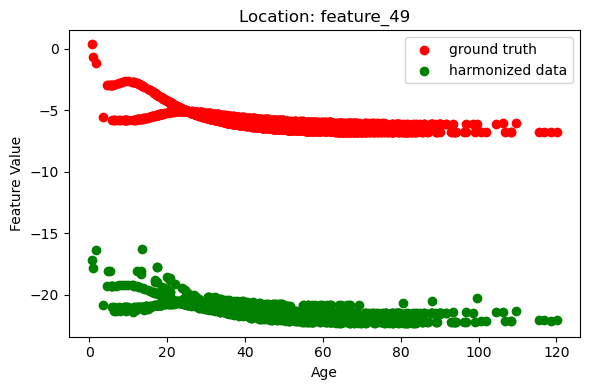

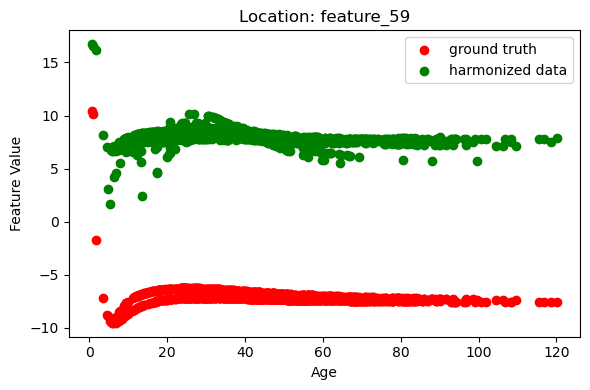

In [47]:
#plot for low variance
for i in position2:
    num = int(i.split('_')[1])
    plt.figure(figsize=(6, 4))
    
    plt.scatter(data["age"], ground_truth.iloc[num, :], color="red",
                label="ground truth" )
    
    plt.scatter(data["age"], combat_data[num, :], color="green",
                label="harmonized data" )
    
    plt.xlabel("Age")
    plt.ylabel("Feature Value")
    plt.title(f"Location: {i}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [51]:
#To show a more obvious comparison of the influence of variance of gamma, I will plot the harmonzied data for simulation 34
path=os.path.join(default_path,'test1',f"N{1010}",f"simulation_{34}")
data=pd.read_csv(os.path.join(path,"data.csv"))
gt_cols=[col for col in data.columns if "ground_truth" in col]
ground_truth=data[gt_cols].T

with open(os.path.join(path,'output_n.pkl'),'rb') as f:
    output=pickle.load(f)
combat_data=output['combat_data']

with open(os.path.join(path,"params.json"),"r") as f:
    params=json.load(f)

gamma_df = pd.DataFrame(
    data=params["gamma"]["data"],
    columns=params["gamma"]["columns"],
    index=params["gamma"]["index"]
)

# Compute quantiles of gamma variance across features
gamma_var = gamma_df.var(axis=0)
quantiles = np.quantile(gamma_var, [0, 0.25, 0.5, 0.75,1])
print("Variance quantiles (min, 25%, median, 75%):", quantiles)

# Identify features with high variance
threshold_high=800
high_var_cols = gamma_var[gamma_var > threshold_high]
position1 = high_var_cols.index.tolist()
print("High variance value:",gamma_var[gamma_var > threshold_high])
print(f"Number of features with variance > {threshold_high}:", len(high_var_cols))
print(f"Columns with variance > {threshold_high}:", positions1)

# Identify features with low variance
threshold_low = 10
low_var_cols = gamma_var[gamma_var < threshold_low]
position2=low_var_cols.index.tolist()
print("Low variance value:",gamma_var[gamma_var < threshold_low])
print(f"Number of features with variance < {threshold_low}:", len(low_var_cols))
print(f"Columns with variance < {threshold_low}:", position2)

Variance quantiles (min, 25%, median, 75%): [4.61849281e-01 3.69956327e+01 9.76625983e+01 2.54266486e+02
 9.72890210e+02]
High variance value: feature_35    815.304492
feature_78    972.890210
dtype: float64
Number of features with variance > 800: 2
Columns with variance > 800: ['feature_35', 'feature_78']
Low variance value: feature_16    0.461849
feature_42    6.696538
feature_58    9.731800
feature_81    7.492094
dtype: float64
Number of features with variance < 10: 4
Columns with variance < 10: ['feature_16', 'feature_42', 'feature_58', 'feature_81']


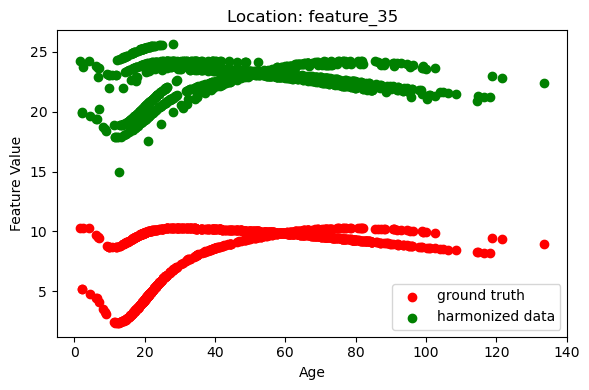

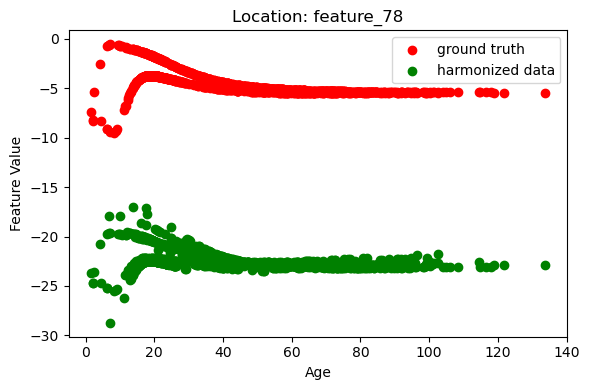

In [52]:
#plot for high variance
for i in position1:
    num = int(i.split('_')[1])
    plt.figure(figsize=(6, 4))
    
    plt.scatter(data["age"], ground_truth.iloc[num, :], color="red",
                label="ground truth" )
    
    plt.scatter(data["age"], combat_data[num, :], color="green",
                label="harmonized data" )
    
    plt.xlabel("Age")
    plt.ylabel("Feature Value")
    plt.title(f"Location: {i}")
    plt.legend()
    plt.tight_layout()
    plt.show()

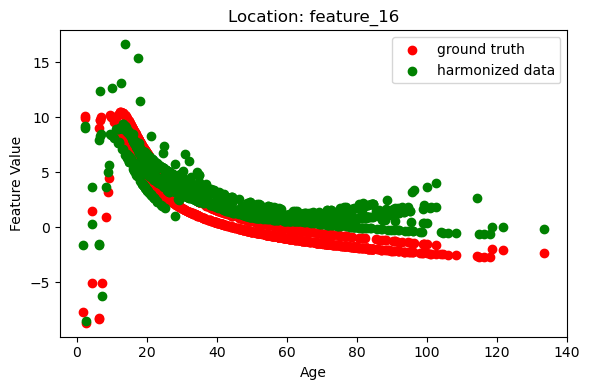

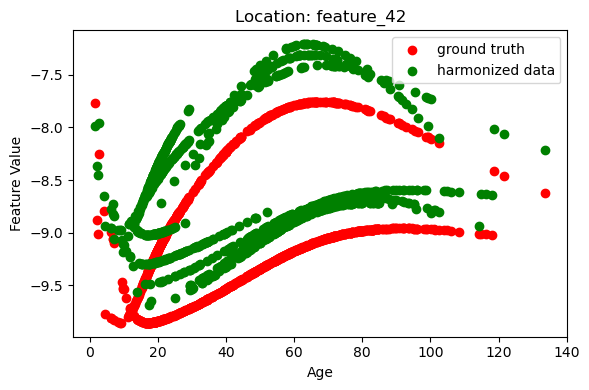

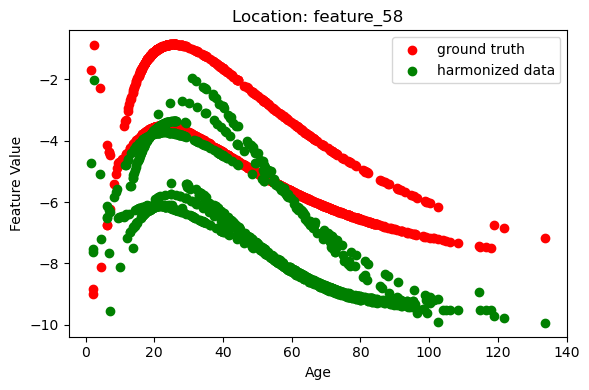

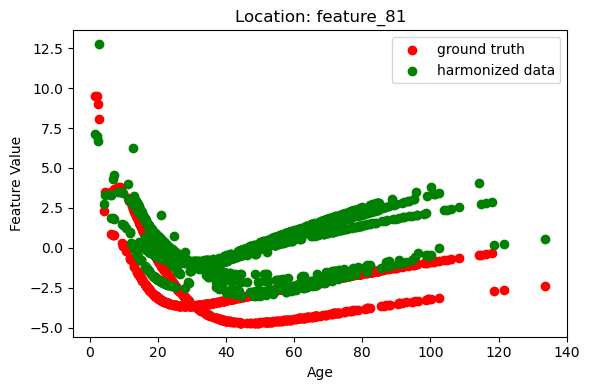

In [53]:
#plot for low variance
for i in position2:
    num = int(i.split('_')[1])
    plt.figure(figsize=(6, 4))
    
    plt.scatter(data["age"], ground_truth.iloc[num, :], color="red",
                label="ground truth" )
    
    plt.scatter(data["age"], combat_data[num, :], color="green",
                label="harmonized data" )
    
    plt.xlabel("Age")
    plt.ylabel("Feature Value")
    plt.title(f"Location: {i}")
    plt.legend()
    plt.tight_layout()
    plt.show()